# 1.0 Read In Data

In [1]:
# Import libraries needed for linear regression computation
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
import scipy.stats as stats
import pylab 
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.preprocessing import scale

from sklearn.model_selection import KFold
import random
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)


Notice that the train data and the test data do not have the same number of columns. that is beacuse the train data has the SalePrice column.

# 2.0 EDA

First step is to view columns with null values. I will remove columns that have more than 90% of nulls. My gut feel is that fence is not a significant factor in determining house price so I will remove that column as well.

In [795]:
# View at nulls
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
null_cols = null_cols[null_cols['count_null'] > 0]

# Remove nulls > 90%
train_data = train_data.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

# Make a new null data dataframe
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
null_cols = null_cols[null_cols['count_null'] > 0]
null_cols

,count_null,percent_null
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtQual,37,0.025342


View the data types of the null columns. Most of the columns are null because the house does not have that specific feature. For example, houses that do not have a garage will have a null values for all garage related columns such as GarageYrBlt. 

For numeric columns such as LotFrontage and MasVnrArea, nulls can be replaced with 0. For the object columns containing nulls, nan will be replaced with 'Not Available'.

In [796]:
# View the dtypes of the columns
null_data = train_data[null_cols.index]
print(null_data.dtypes)
print(null_data.head())

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(0)
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

# Replace any null values in categorical variables with 'Not Available'
for i in train_data.columns:
    if train_data[i].dtypes == 'object':
        train_data[i] = train_data[i].fillna('Not_Available')

FireplaceQu      object
LotFrontage     float64
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
BsmtExposure     object
BsmtFinType2     object
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
MasVnrArea      float64
MasVnrType       object
Electrical       object
dtype: object
  FireplaceQu  LotFrontage GarageType  GarageYrBlt GarageFinish GarageQual  \
0         NaN         65.0     Attchd       2003.0          RFn         TA   
1          TA         80.0     Attchd       1976.0          RFn         TA   
2          TA         68.0     Attchd       2001.0          RFn         TA   
3          Gd         60.0     Detchd       1998.0          Unf         TA   
4          TA         84.0     Attchd       2000.0          RFn         TA   

  GarageCond BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  \
0         TA           No          Unf       Gd       TA          GLQ   
1         T

Moving on to columns that are correlated with SalePrice

#### First let's take a look at all the numeric features and their correlation with SalePrice

In [797]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Drop any features that have close to 0 (+- 5) correlation with SalePrice. Will keep BsmtHalf bath to combine with other bath columns

In [798]:
train_data = train_data.drop(columns=['YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id'])

Combine the bath features and investigate if it leads to a better correlation. Based on the output below, the combination of the bath column leads to a corelation of 0.63!

In [799]:
train_data['NumBath'] = (train_data['FullBath'] + train_data['HalfBath']/2 + 
                       train_data['BsmtHalfBath']/2 + train_data['BsmtFullBath'])

train_data = train_data.drop(columns = ['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Let's combine the 1st, 2nd and basement SF and investigate how it correlates with SalePrice. LivingSF has a 0.78 correlation with SalePrice. '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1' as they will have high correlation with LivingSF feature.

In [800]:
train_data['LivingSF'] = (train_data['1stFlrSF'].fillna(0) + train_data['2ndFlrSF'].fillna(0) 
                               + train_data['TotalBsmtSF'].fillna(0))

train_data = train_data.drop(columns = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's combine the LotArea and LotFrontage features to determine if they will have a better correlation with SalePrice. TotalLotArea has a correlation of 0.26 which is slightly better than the individual correlations of LotArea and LotFrontage. Thus, LotArea and LotFrontage columns will be removed while keeping TotalLotArea

In [801]:
train_data['TotalLotArea'] = train_data['LotArea'] + train_data['LotFrontage']

train_data = train_data.drop(columns = ['LotArea', 'LotFrontage'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's combine all the SF features that are outside of the house. For example, Garage, Porches, Pools etc that are not necessarily used for living. The addition of all the features give a correlation of 0.65. 

In [802]:
# combine total SF features outside
train_data['NonLivingSF'] = (train_data['EnclosedPorch'] + train_data['PoolArea'] + train_data['GarageArea'] + 
                             train_data['ScreenPorch'] + train_data['OpenPorchSF'] +  train_data['WoodDeckSF'])

train_data = train_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


The MSSubClass field should be seen as a categorical variable instead of a numeric

In [803]:
train_data['MSSubClassCat'] = train_data['MSSubClass'].astype('category')

train_data = train_data.drop(columns = ['MSSubClass'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


So far we have seen the correlation of all numeric variables with SalePrice. Next step is to see how all the numeric variable are corelated with each other.

From the heatmap below, (GrLivArea and LivingSF), (GarageYrBlt and YearBuilt), (OverallQual and LivingSF), (GarageCars and NonLivingSF) have a strong correlation with each other.

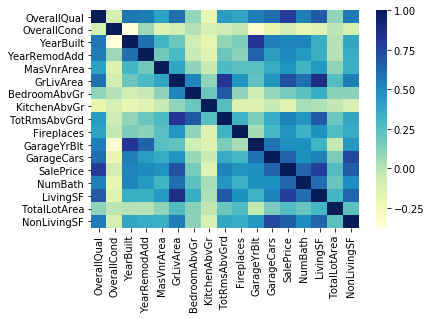

In [804]:
corr = train_data.corr()
sns.heatmap(corr, cmap="YlGnBu")

Let's take a look at the KitchenAbvGr and OverallCond columns. Based on the plots, I will delete the KitchenAbvGr as there is a large variance with houses with one kitchen. OverallCond seems like it should have a positive correlation as well, however, due to the large variance with OverallCond of 5, there is a negative correlation. OverallCond column will be deleted as well

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


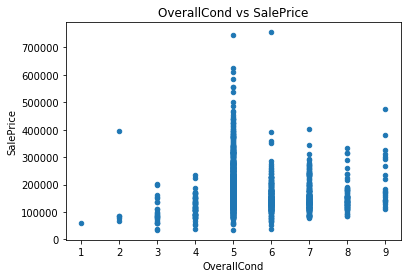

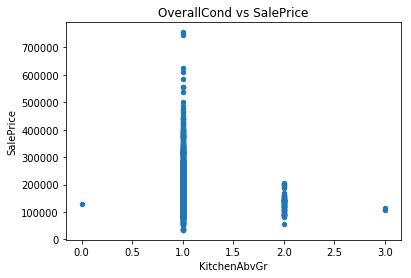

In [805]:
OverallCond_vs_SalePrice = train_data.plot(
    kind="scatter", x='OverallCond', y='SalePrice', title = "OverallCond vs SalePrice")

KitchenAbvGr_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenAbvGr', y='SalePrice', title = "OverallCond vs SalePrice")

train_data = train_data.drop(columns = ['KitchenAbvGr', 'OverallCond'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Before we deal with features that are highly correlated with each other, let's take a look at the categorical variables. Below are all the categorical vairable columns

In [806]:
train_data.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Removing BsmtFinType2 and BsmtFinType1 as their respective numeric features were dropped above. Furthermore, notice some features are the secondary feature of another (eg Exterior1st_VinylSd	Exterior2nd_VinylSd). The secondary feature will be removed in this case (i.e 'Exterior2nd', 'Condition2').

In [807]:
train_data = train_data.drop(columns= ['BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 'Condition2'])

Let's change 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageQual', 'GarageCond' to numeric vairables (similar to OverallCond)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
ExterQualInt,0.682639
KitchenQualInt,0.659600
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
BsmtQualInt,0.604816


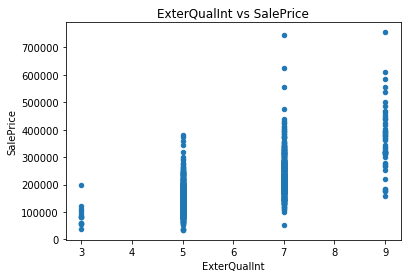

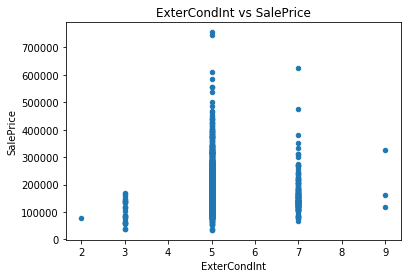

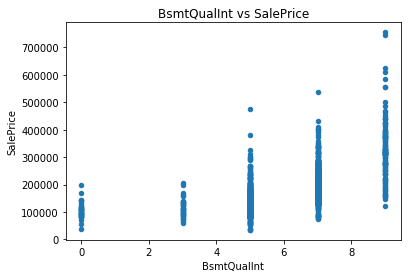

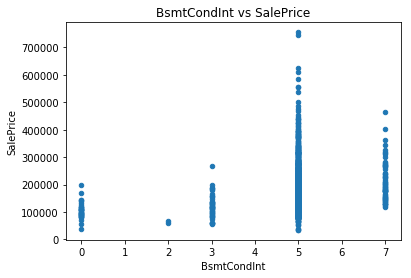

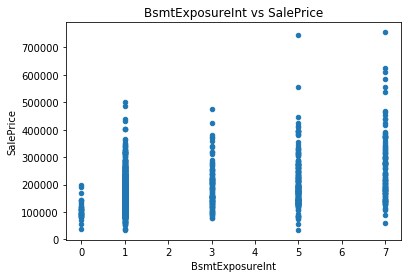

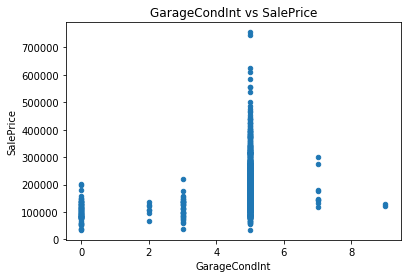

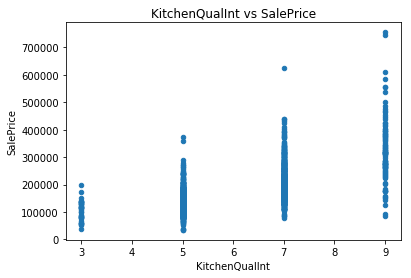

In [808]:
# Add int variables for ExterQual and ExterCond
train_data['ExterQualInt'] =  np.where(train_data['ExterQual'] == "Ex", 9, 
                                        np.where(train_data['ExterQual'] == "Gd", 7, 
                                                np.where(train_data['ExterQual'] == "TA", 5, 
                                                        np.where(train_data['ExterQual'] == "Fa", 3, 
                                                                np.where(train_data['ExterQual'] == "Po", 2,0)))))
train_data['ExterCondInt'] =  np.where(train_data['ExterCond'] == "Ex", 9, 
                                         np.where(train_data['ExterCond'] == "Gd", 7, 
                                                np.where(train_data['ExterCond'] == "TA", 5, 
                                                        np.where(train_data['ExterCond'] == "Fa", 3, 
                                                                np.where(train_data['ExterCond'] == "Po", 2,0)))))

# Add int variables for all categorical basement variables
train_data['BsmtQualInt'] =  np.where(train_data['BsmtQual'] == "Ex", 9, 
                                        np.where(train_data['BsmtQual'] == "Gd", 7, 
                                                np.where(train_data['BsmtQual'] == "TA", 5, 
                                                        np.where(train_data['BsmtQual'] == "Fa", 3, 
                                                                np.where(train_data['BsmtQual'] == "Po", 2,0)))))

train_data['BsmtCondInt'] =  np.where(train_data['BsmtCond'] == "Ex", 9, 
                                        np.where(train_data['BsmtCond'] == "Gd", 7, 
                                                np.where(train_data['BsmtCond'] == "TA", 5, 
                                                        np.where(train_data['BsmtCond'] == "Fa", 3, 
                                                                np.where(train_data['BsmtCond'] == "Po", 2,0)))))

train_data['BsmtExposureInt'] =  np.where(train_data['BsmtExposure'] == "Gd", 7, 
                                        np.where(train_data['BsmtExposure'] == "Av", 5, 
                                                np.where(train_data['BsmtExposure'] == "Mn", 3, 
                                                        np.where(train_data['BsmtExposure'] == "No", 1, 0))))

# Add int variables for GarageQual and GarageCond
train_data['GarageCondInt'] =  np.where(train_data['GarageCond'] == "Ex", 9, 
                                        np.where(train_data['GarageCond'] == "Gd", 7, 
                                                np.where(train_data['GarageCond'] == "TA", 5, 
                                                        np.where(train_data['GarageCond'] == "Fa", 3, 
                                                                np.where(train_data['GarageCond'] == "Po", 2,0)))))

train_data['GarageQualInt'] =  np.where(train_data['GarageQual'] == "Ex", 9, 
                                        np.where(train_data['GarageQual'] == "Gd", 7, 
                                                np.where(train_data['GarageQual'] == "TA", 5, 
                                                        np.where(train_data['GarageQual'] == "Fa", 3, 
                                                                np.where(train_data['GarageQual'] == "Po", 2,0)))))
# Add interaction variables for KitchenQual
train_data['KitchenQualInt'] =  np.where(train_data['KitchenQual'] == "Ex", 9, 
                                        np.where(train_data['KitchenQual'] == "Gd", 7, 
                                                np.where(train_data['KitchenQual'] == "TA", 5, 
                                                        np.where(train_data['KitchenQual'] == "Fa", 3, 
                                                                np.where(train_data['KitchenQual'] == "Po", 2,0)))))

train_data = train_data.drop(columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                        'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])

ExterQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterQualInt', y='SalePrice', title = "ExterQualInt vs SalePrice")
ExterCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterCondInt', y='SalePrice', title = "ExterCondInt vs SalePrice")
BsmtQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtQualInt', y='SalePrice', title = "BsmtQualInt vs SalePrice")
BsmtCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtCondInt', y='SalePrice', title = "BsmtCondInt vs SalePrice")
BsmtExposureInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtExposureInt', y='SalePrice', title = "BsmtExposureInt vs SalePrice")
GarageCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='GarageCondInt', y='SalePrice', title = "GarageCondInt vs SalePrice")
KitchenQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenQualInt', y='SalePrice', title = "KitchenQualInt vs SalePrice")
                                        
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Delete ExterCondInt as it has a correlation of almost 0. Based on the graphs, BsmtExposureInt, GarageCondInt and BsmtCondInt will be deleted as they visually do not have a clear linear relationship.

In [809]:
train_data = train_data.drop(columns= ['ExterCondInt', 'BsmtExposureInt', 'GarageCondInt', 'BsmtCondInt'])

Let's one hot encode the rest of the categorical variables and delete any features that have 'Not Available' present in the title

In [810]:
train_data = pd.get_dummies(train_data, drop_first=True)

# Delete any Not_Available columns (no use in the model)
train_data = train_data[train_data.columns.drop(list(train_data.filter(regex='Not_Available')))]

print('Shape of the training dataset is now:', train_data.shape)

Shape of the training dataset is now: (1460, 174)


Let look at how each feature correlates with SalePrice. I will delete all features that have 0 +- 5% correlation with SalePrice as these features will not be effective in predicting SalePrice. The following are features that will be deleted from the model:

In [811]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)
saleprice_corr = saleprice_corr.reset_index()
saleprice_corr.columns = ['Feature', 'SalePrice']
features_to_delete = saleprice_corr[(saleprice_corr['SalePrice'] < 0.05) & (saleprice_corr['SalePrice'] > -0.05)]
features_to_delete 

,Feature,SalePrice
23,Street_Pave,0.041036
25,LotShape_IR3,0.036720
28,LandContour_Low,0.045528
29,LandContour_Lvl,-0.027545
30,Utilities_NoSeWa,-0.014314
32,LotConfig_FR2,-0.006859
33,LotConfig_FR3,0.018186
35,LandSlope_Mod,0.042981
36,LandSlope_Sev,0.027998
37,Neighborhood_Blueste,-0.020250


In [812]:
features_to_delete = features_to_delete['Feature'].unique()
train_data = train_data.drop(columns = features_to_delete)
print('Shape of the training dataset is now:', train_data.shape)

Shape of the training dataset is now: (1460, 111)


So far, features that have a low correlation with SalePrice have been removed from the dataset. However, collinearity between features itself must be taken care of as well.

In [813]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
# saleprice_corr = saleprice_corr.reset_index()
# saleprice_corr.columns = ['Feature', 'SalePrice']
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
ExterQualInt,0.682639
KitchenQualInt,0.659600
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
BsmtQualInt,0.604816


The following are variables that have greater than 0.6 correlation with each other. For any features that have a correlation value greater than 90, I will remove the feature that has the least correlation with SalePrice.

In [816]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.60:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df
# https://onlinecourses.science.psu.edu/stat501/node/346/

,col1,col2,correlation
34,BldgType_Duplex,MSSubClassCat_90,1.000000
46,SaleType_New,SaleCondition_Partial,0.986819
33,BldgType_2fmCon,MSSubClassCat_190,0.983395
36,HouseStyle_1.5Unf,MSSubClassCat_45,0.925181
14,GrLivArea,LivingSF,0.874373
30,MSZoning_FV,Neighborhood_Somerst,0.862807
6,YearBuilt,GarageYrBlt,0.825667
12,GrLivArea,TotRmsAbvGrd,0.825489
1,OverallQual,SalePrice,0.790982
21,SalePrice,LivingSF,0.782260


In [817]:
# print(train_data.shape)
# for index, row in corr_df.iterrows():
#     if str(row['col1']) == 'SalePrice' or str(row['col2']) == 'SalePrice':
#         continue
#     if abs(row['correlation']) > 0.8:
        
#         if abs(saleprice_corr.loc[row['col1'], 'SalePrice']) >= abs(saleprice_corr.loc[row['col2'], 'SalePrice']) :
#             train_data = train_data.drop(columns = [row['col2']])
#         else:
#             train_data = train_data.drop(columns = [row['col1']])
            
# print(train_data.shape)          

In [818]:
# correlation_mat = train_data.corr()
# corr_df = []
# for i in range(0, correlation_mat.shape[0], 1):
#     for j in range(i+1, correlation_mat.shape[1],1):
#         if abs(correlation_mat.iloc[i,j]) >= 0.60:
#             corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
# corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
# corr_df = corr_df.sort_values(by='correlation', ascending=False)
# corr_df

Paramaters that I can play with:
    - Regulization coefficient

Let's describe the data and see if there are any outliers. First, look at the numerical features with high ranges such as LivingSF, NonLivingSF, TotalLotArea and GrLivArea. Remove outliers in the column

In [819]:
# Look at outliers
train_data.describe()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,SalePrice,NumBath,LivingSF,TotalLotArea,NonLivingSF,ExterQualInt,BsmtQualInt,GarageQualInt,KitchenQualInt,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_Reg,LandContour_HLS,LotConfig_CulDSac,LotConfig_Inside,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_CompShg,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Heating_GasA,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Typ,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial,MSSubClassCat_30,MSSubClassCat_45,MSSubClassCat_50,MSSubClassCat_60,MSSubClassCat_90,MSSubClassCat_120,MSSubClassCat_160,MSSubClassCat_180,MSSubClassCat_190
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1971.267808,1984.865753,103.117123,1515.463699,2.866438,6.517808,0.613014,1978.506164,1.767123,180921.195890,2.210616,2567.048630,10574.451370,653.658904,5.791781,6.003425,4.678082,6.023288,0.044521,0.010959,0.788356,0.149315,0.028082,0.633562,0.034247,0.064384,0.720548,0.010959,0.039726,0.019178,0.102740,0.034932,0.068493,0.025342,0.011644,0.033562,0.154110,0.028082,0.05274,0.077397,0.017123,0.050685,0.058904,0.017123,0.026027,0.007534,0.055479,0.863014,0.021233,0.035616,0.029452,0.009589,0.497260,0.304795,0.025342,0.781507,0.195890,0.982192,0.004110,0.001370,0.041781,0.152055,0.150685,0.352740,0.141096,0.017808,0.304795,0.591781,0.087671,0.434247,0.443151,0.016438,0.978082,0.004795,0.002740,0.033562,0.165068,0.293151,0.934932,0.018493,0.913699,0.003425,0.021233,0.023288,0.931507,0.260274,0.013699,0.214384,0.595890,0.060274,

Note that removing outliers for living SF made the correlation factor with SalePrice increase from 0.782260 to 0.813394

In [782]:
LivingSF_Q99 = train_data['LivingSF'].quantile(.99)
print(LivingSF_Q99)
test = train_data[train_data['LivingSF'] < LivingSF_Q99]
print('Removed ',train_data.shape[0] - test.shape[0], 'rows')
saleprice_corr = test[test.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

4845.250000000002
Removed  15 rows


,SalePrice
SalePrice,1.000000
LivingSF,0.813394
OverallQual,0.802829
GrLivArea,0.702836
ExterQualInt,0.697601
KitchenQualInt,0.667242
NonLivingSF,0.663558
GarageCars,0.651359
NumBath,0.627256
BsmtQualInt,0.616146


Note that removing outliers for living SF made the correlation factor with SalePrice increase from 0.255769 to 0.386246

In [783]:
TotalLotArea_Q99 = train_data['TotalLotArea'].quantile(.99)
print(TotalLotArea_Q99)
test = train_data[train_data['TotalLotArea'] < TotalLotArea_Q99]
print('Removed ',train_data.shape[0] - test.shape[0], 'rows')
saleprice_corr = test[test.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

37597.57000000022
Removed  15 rows


,SalePrice
SalePrice,1.000000
LivingSF,0.830298
OverallQual,0.800999
GrLivArea,0.732695
ExterQualInt,0.692092
KitchenQualInt,0.665912
NonLivingSF,0.659352
GarageCars,0.640552
NumBath,0.631563
BsmtQualInt,0.608887


In [784]:
GrLivArea_Q99 = train_data['GrLivArea'].quantile(.99)
print(GrLivArea_Q99)
test = train_data[train_data['GrLivArea'] < GrLivArea_Q99]
print('Removed ',train_data.shape[0] - test.shape[0], 'rows')
saleprice_corr = test[test.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

3123.4800000000023
Removed  15 rows


,SalePrice
SalePrice,1.000000
LivingSF,0.817639
OverallQual,0.802568
ExterQualInt,0.708039
GrLivArea,0.701919
KitchenQualInt,0.673981
NonLivingSF,0.660707
GarageCars,0.651746
NumBath,0.628120
BsmtQualInt,0.626080


In [785]:
SalePrice_Q99 = train_data['SalePrice'].quantile(.99)
print(SalePrice_Q99)
test = train_data[train_data['SalePrice'] < SalePrice_Q99]
print('Removed ',train_data.shape[0] - test.shape[0], 'rows')
saleprice_corr = test[test.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

442567.0100000005
Removed  15 rows


,SalePrice
SalePrice,1.000000
OverallQual,0.797012
LivingSF,0.760318
ExterQualInt,0.678831
GrLivArea,0.678376
KitchenQualInt,0.655216
GarageCars,0.652390
NonLivingSF,0.652161
NumBath,0.632802
BsmtQualInt,0.614126


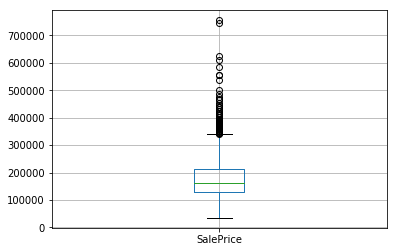

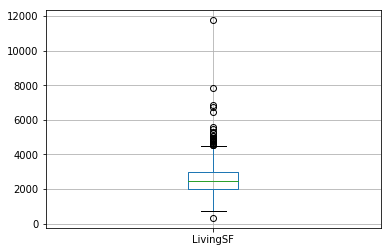

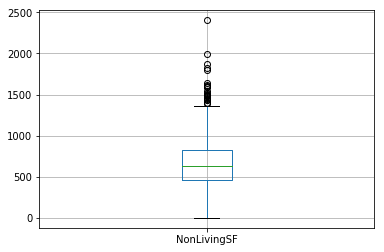

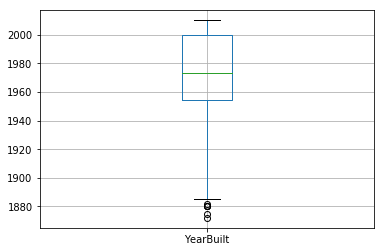

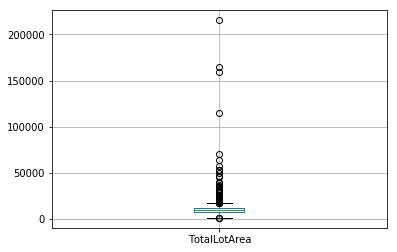

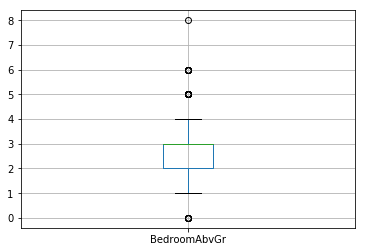

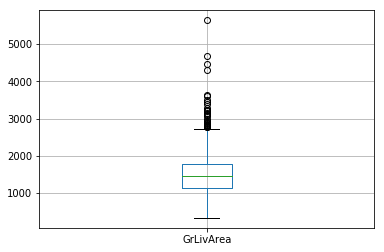

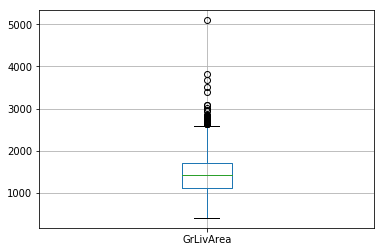

In [786]:
boxplot = train_data.boxplot(column=['SalePrice'])
plt.show()
boxplot = train_data.boxplot(column=['LivingSF'])
plt.show()
boxplot = train_data.boxplot(column=['NonLivingSF'])
plt.show()
boxplot = train_data.boxplot(column=['YearBuilt'])
plt.show()
boxplot = train_data.boxplot(column=['TotalLotArea'])
plt.show()
boxplot = train_data.boxplot(column=['BedroomAbvGr'])
plt.show()
boxplot = train_data.boxplot(column=['GrLivArea'])
plt.show()
boxplot = test_data.boxplot(column=['GrLivArea'])
plt.show()

In [2]:
def apply_pca_on_columns(model_data, ori_cols, pca_cols,num_components):
    # first lets start with 'GarageYrBlt', 'GarageCondQual'
    df = model_data[ori_cols]
    pca = PCA(n_components=num_components)
    df_components = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = df_components, columns = pca_cols)
    model_data = pd.concat([model_data, df_pca], axis=1)
    model_data= model_data.drop(columns = ori_cols)
    
    return model_data

In [861]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df



,col1,col2,correlation
12,BldgType_Duplex,MSSubClassCat_90,1.000000
20,SaleType_New,SaleCondition_Partial,0.986819
11,BldgType_2fmCon,MSSubClassCat_190,0.983395
13,HouseStyle_1.5Unf,MSSubClassCat_45,0.925181
5,GrLivArea,LivingSF,0.874373
9,MSZoning_FV,Neighborhood_Somerst,0.862807
2,YearBuilt,GarageYrBlt,0.825667
3,GrLivArea,TotRmsAbvGrd,0.825489
0,OverallQual,SalePrice,0.790982
7,SalePrice,LivingSF,0.782260


In [860]:
# print(corr_df)
# if corr_df.shape[0] > 0:
#     keep_going = True
# else:
#     keep_going = False
    
# while keep_going:
#     ori_cols = []
#     pca_cols = []
#     for index, row in corr_df.iterrows():
#         if row['correlation'] > 0.9:
#             ori_cols.append(row['col1'])
#             ori_cols.append(row['col2'])
#             pca_cols.append(str(row['col1']) + '_' + str(row['col2']))
#             print(pca_cols )
#             train_test = apply_pca_on_columns(train_test, ori_cols, pca_cols,1)
#             break

#     correlation_mat = train_test.corr()
    
#     corr_df = []
#     for i in range(0, correlation_mat.shape[0], 1):
#         for j in range(i+1, correlation_mat.shape[1],1):
#             if abs(correlation_mat.iloc[i,j]) >= 0.9:
#                 corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

#     corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
    
#     type(corr_df)
#     if corr_df.shape[0]> 0:
#         print(corr_df.shape)
#         continue
#     else:
#         keep_going = False

[]


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
correlation_mat = train_test.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.9:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

# Feature Enginerring

In [3]:
# def feature_eng(model_data, max_predictor_corr_delete, max_predictor_corr_dim_red, min_response_corr):
def feature_eng(model_data, min_corr_saleprice, corr_features_thres, is_train):

    id_col = model_data['Id']
    
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0)
    model_data['LotFrontage'] = model_data['LotFrontage'].fillna(0)
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)

    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
            
    model_data['NumBath'] = (model_data['FullBath'] + model_data['HalfBath']/2 + 
                       model_data['BsmtHalfBath']/2 + model_data['BsmtFullBath'])
    
    
    model_data['LivingSF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))

    
    model_data['TotalLotArea'] = model_data['LotArea'] + model_data['LotFrontage']

    
    
    # combine total SF features outside
    model_data['NonLivingSF'] = (model_data['EnclosedPorch'] + model_data['PoolArea'] + model_data['GarageArea'] + 
                             model_data['ScreenPorch'] + model_data['OpenPorchSF'] +  model_data['WoodDeckSF'])
    
    model_data['MSSubClassCat'] = model_data['MSSubClass'].astype('category')
    
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))

    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))


    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))

    model_data = model_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 
                                          'OpenPorchSF', 'WoodDeckSF', 'MSSubClass', 'KitchenAbvGr', 
                                          'OverallCond', 'BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 
                                          'Condition2', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
                                          'BsmtFinSF1', 'LotArea', 'LotFrontage', 'YrSold', 'LowQualFinSF', 
                                          'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id', 'FullBath', 
                                          'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'PoolQC', 'MiscFeature', 
                                          'Alley', 'Fence', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                          'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])
    
    model_data = pd.get_dummies(model_data, drop_first=True)

    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
    
    if is_train:
        # Delete any variables that have less than a threshold of correlation with SalePrice
        saleprice_corr = model_data[model_data.columns].corr()['SalePrice']
        saleprice_corr = pd.DataFrame(saleprice_corr)
        saleprice_corr.sort_values(by='SalePrice', ascending = False)
        saleprice_corr = saleprice_corr.reset_index()
        saleprice_corr.columns = ['Feature', 'SalePrice']
        features_to_delete = saleprice_corr[
            (saleprice_corr['SalePrice'] < min_corr_saleprice) & (saleprice_corr['SalePrice'] > -min_corr_saleprice)]
        features_to_delete = features_to_delete['Feature'].unique()
        model_data = model_data.drop(columns = features_to_delete)
        saleprice_corr = saleprice_corr.set_index('Feature')

        # The following shows correlations of features with each other
        correlation_mat = model_data.corr()
        corr_df = []
        for i in range(0, correlation_mat.shape[0], 1):
            for j in range(i+1, correlation_mat.shape[1],1):
                if abs(correlation_mat.iloc[i,j]) >= corr_features_thres:
                    corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
        corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
        corr_df = corr_df.sort_values(by='correlation', ascending=False)
#         print(corr_df)
        
        # Deletes one of two highly correlated features if it is greater than the threshold. Deletes feature that has
        # lower correlation with SalePrice
        for index, row in corr_df.iterrows():
            if (str(row['col1']) == 'SalePrice') or (str(row['col2']) == 'SalePrice'):
                continue
            else:
                if abs(saleprice_corr.loc[row['col1'], 'SalePrice']) >= abs(saleprice_corr.loc[row['col2'], 'SalePrice']) :
                    if row['col2'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col2']])
                else:
                    if row['col1'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col1']])
        
        model_data = model_data.drop(columns = ['SalePrice'])
#         model_data = MinMaxScaler().fit_transform(model_data)
#         model_data_col = model_data.columns
#         model_data = pd.DataFrame(model_data, columns=model_data_col)
    
    
    model_data_col = model_data.columns
    model_data = MinMaxScaler().fit_transform(model_data)
#     model_data = scale(model_data)
    model_data = pd.DataFrame(model_data, columns=model_data_col)
        
    return model_data, id_col
    

In [179]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


# Linear Regression

In [4]:
def run_model_inputs(train_data, train_saleprice, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    log_scores = []
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
        print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([model.rsquared_adj, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

        # fitted values
        model_fitted = pd.DataFrame(model.fittedvalues)

        # model residuals
        model_residuals = pd.DataFrame(model.resid)

        # Residual plot
        residual_plot = plt.scatter(model_fitted , model_residuals)
        plt.show()

    scores = pd.DataFrame(scores, columns = ['adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
    print(scores)
    print(scores.describe())
    

#     test_predictions = model.predict(sm.add_constant(test_data))
#     test_predictions = pd.DataFrame(test_predictions)
#     test_predictions.columns = ['SalePrice']
#     test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
#     return test_predictions

def run_model_inputs_pca(train_data, train_saleprice, k):
#     kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
#     print(kf)
    log_scores = []
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
#         print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([model_data.shape[1], model.rsquared_adj, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

    scores = pd.DataFrame(scores, columns = ['num_components', 'adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
#     print(scores)
#     print(scores.describe())
    

#     test_predictions = model.predict(sm.add_constant(test_data))
#     test_predictions = pd.DataFrame(test_predictions)
#     test_predictions.columns = ['SalePrice']
#     test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return scores

Shape of train data before: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 36)
KFold(n_splits=5, random_state=325, shuffle=True)
                0
533 -18517.506854


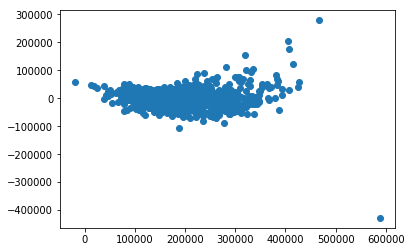

                0
533 -24956.512013


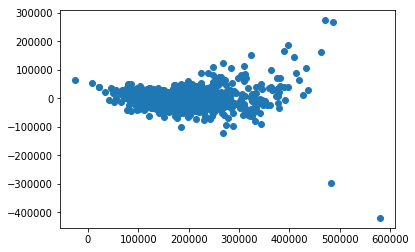

                0
533 -22619.943133


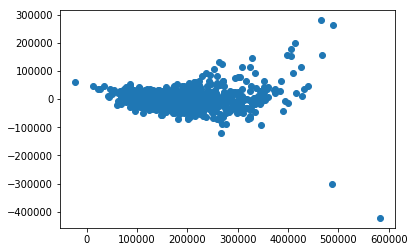

                0
533 -25826.628484


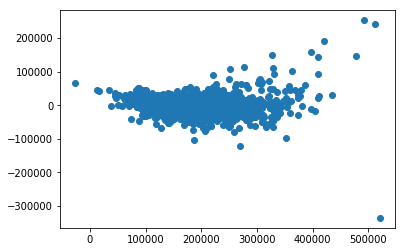

Empty DataFrame
Columns: [0]
Index: []


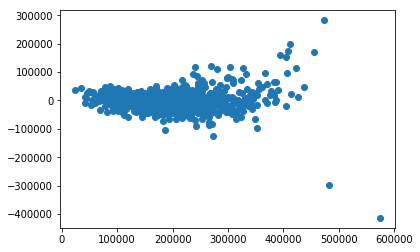

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.837277      11.78     12.373971  0.593971       30678          40452
1  0.813925      12.13     11.760833  0.369167       33776          28809
2  0.814637      11.98     13.135325  1.155325       34081          27330
3  0.847034      11.79     12.746502  0.956502       30656          42032
4  0.824237      11.88     11.420477  0.459523       33100          31855
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.827422  11.912000     12.287422  0.706898  32458.200000   
std    0.014470   0.146185      0.701084  0.335931   1673.246903   
min    0.813925  11.780000     11.420477  0.369167  30656.000000   
25%    0.814637  11.790000     11.760833  0.459523  30678.000000   
50%    0.824237  11.880000     12.373971  0.593971  33100.000000   
75%    0.837277  11.980000     12.746502  0.956502  33776.000000   
max    0.847

In [73]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data before:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.2, .75, True)
print('Shape of train data:', train_data.shape)

run_model_inputs(train_data, train_saleprice, 5)

# Back to Feature Engineering

Apply PCA on highly correlated features

In [74]:
def apply_pca_on_columns(model_data, ori_cols, pca_cols,num_components):
    # first lets start with 'GarageYrBlt', 'GarageCondQual'
    for i in ori_cols:
        if i not in model_data.columns:
            return model_data
        
    df = model_data[ori_cols]
    pca = PCA(n_components=num_components)
    df_components = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = df_components, columns = pca_cols)
    model_data = pd.concat([model_data, df_pca], axis=1)
    model_data= model_data.drop(columns = ori_cols)
    
    return model_data

### Only after removing features that have less than 0.05 correlation with 

In [155]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data before:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.2, 2, True)
print('Shape of train data:', train_data.shape)

Shape of train data before: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 45)


In [156]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

,col1,col2,correlation
12,SaleType_New,SaleCondition_Partial,0.986819
3,GarageYrBlt,GarageQualInt,0.929219
2,GrLivArea,LivingSF,0.874373
1,GrLivArea,TotRmsAbvGrd,0.825489
7,HouseStyle_2Story,MSSubClassCat_60,0.762743
4,GarageCars,NonLivingSF,0.747685
0,OverallQual,ExterQualInt,0.726278
5,ExterQualInt,KitchenQualInt,0.716122
10,GarageType_Attchd,GarageType_Detchd,-0.729272
13,SaleType_WD,SaleCondition_Partial,-0.769559


#### Apply PCA on all columns that have a correlation greater than 0.9

In [157]:
ori_cols = ['BldgType_Duplex', 'MSSubClassCat_90']
pca_cols = ['BldgType_Duplex_MSSubClassCat_90']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['SaleType_New', 'SaleCondition_Partial']
pca_cols = ['SaleType_New_SaleCondition_Partial']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['HouseStyle_1.5Unf', 'MSSubClassCat_45']
pca_cols = ['SaleType_New_MSSubClassCat_45']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['BldgType_2fmCon', 'MSSubClassCat_190']
pca_cols = ['BldgType_2fmCon_MSSubClassCat_190']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['GarageYrBlt', 'GarageQualInt']
pca_cols = ['GarageYrBlt_GarageQualInt']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['RoofStyle_Gable', 'RoofStyle_Hip']
pca_cols = ['RoofStyle_Gable_RoofStyle_Hip']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

(1460, 42)
KFold(n_splits=5, random_state=23783, shuffle=True)
Empty DataFrame
Columns: [0]
Index: []


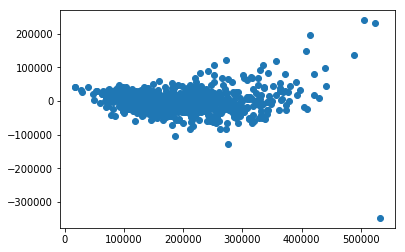

               0
533 -29956.97766


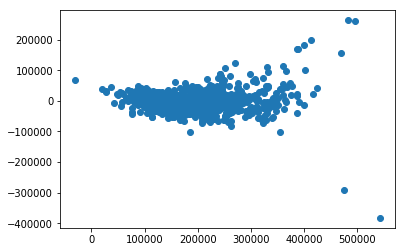

                0
533 -21063.703688


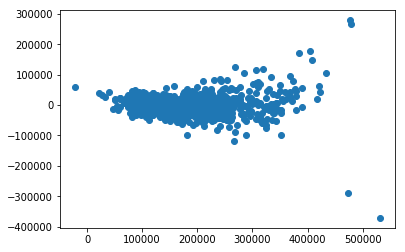

                0
533 -32396.431574


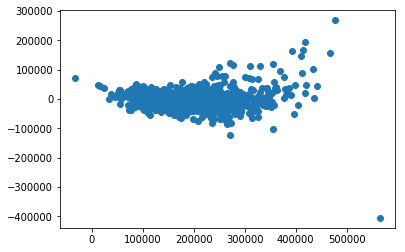

                0
533 -29918.541677


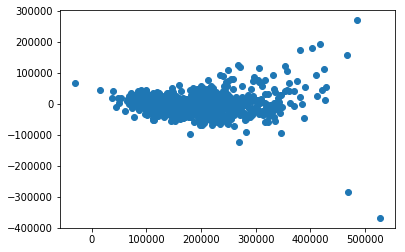

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.850536      11.63     12.590367  0.960367       30113          41714
1  0.825015      12.04     11.575061  0.464939       33122          28268
2  0.825448      11.72     12.586529  0.866529       32319          32483
3  0.838918      11.91     12.093407  0.183407       31464          35147
4  0.824424      11.80     12.433388  0.633388       32265          32569
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.832868  11.820000     12.255750  0.621726  31856.600000   
std    0.011584   0.160468      0.430880  0.312829   1137.554087   
min    0.824424  11.630000     11.575061  0.183407  30113.000000   
25%    0.825015  11.720000     12.093407  0.464939  31464.000000   
50%    0.825448  11.800000     12.433388  0.633388  32265.000000   
75%    0.838918  11.910000     12.586529  0.866529  32319.000000   
max    0.850

In [158]:
print(train_data.shape)
run_model_inputs(train_data, train_saleprice, 5)

#### The validate RMSE gets slightly better but the difference in error decreases. Let's apply pca on columns have a correlation greater than 0.8 and see if it improves

In [159]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

,col1,col2,correlation
2,GrLivArea,LivingSF,0.874373
1,GrLivArea,TotRmsAbvGrd,0.825489
6,HouseStyle_2Story,MSSubClassCat_60,0.762743
3,GarageCars,NonLivingSF,0.747685
0,OverallQual,ExterQualInt,0.726278
4,ExterQualInt,KitchenQualInt,0.716122
8,GarageType_Attchd,GarageType_Detchd,-0.729272
9,SaleType_WD,SaleType_New_SaleCondition_Partial,-0.774152
7,Foundation_CBlock,Foundation_PConc,-0.781558
5,MSZoning_RL,MSZoning_RM,-0.808585


In [160]:
ori_cols = ['GrLivArea', 'LivingSF']
pca_cols = ['GrLivArea_LivingSF']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['MSZoning_FV', 'Neighborhood_Somerst']
pca_cols = ['MSZoning_FV_Neighborhood_Somerst']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['MSZoning_RL', 'MSZoning_RM']
pca_cols = ['MSZoning_RL_MSZoning_RM']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

(1460, 40)
KFold(n_splits=5, random_state=23645, shuffle=True)
                0
533 -23327.406691


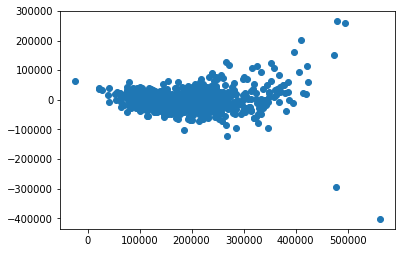

                0
533 -27336.685131


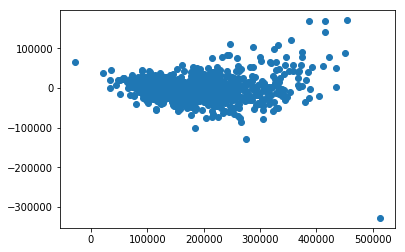

                0
533 -26821.037994


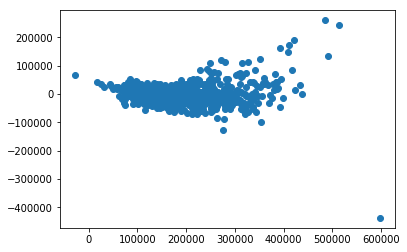

Empty DataFrame
Columns: [0]
Index: []


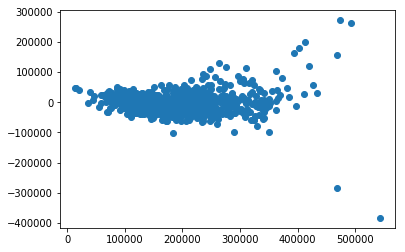

                0
533 -24673.667191


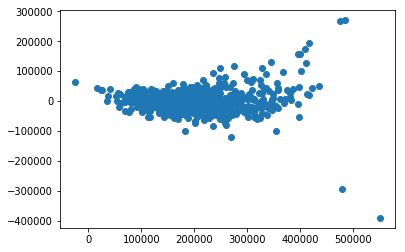

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.823323      12.03     10.749053  1.280947       33119          28632
1  0.861878      11.19     13.285943  2.095943       28396          45631
2  0.833854      11.86     12.187638  0.327638       32392          32066
3  0.822063      11.66     13.151488  1.491488       32609          31230
4  0.822617      11.70     12.021294  0.321294       32935          29732
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.832747  11.688000     12.279083  1.103462  31890.200000   
std    0.016995   0.314436      1.023556  0.771488   1973.541664   
min    0.822063  11.190000     10.749053  0.321294  28396.000000   
25%    0.822617  11.660000     12.021294  0.327638  32392.000000   
50%    0.823323  11.700000     12.187638  1.280947  32609.000000   
75%    0.833854  11.860000     13.151488  1.491488  32935.000000   
max    0.861

In [161]:
print(train_data.shape)
run_model_inputs(train_data, train_saleprice, 5)

#### The validate RMSE gets slightly worse but the difference in error continues to decrease. Let's apply pca on columns have a correlation greater than 0.7 and see if it improves

In [162]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

,col1,col2,correlation
1,TotRmsAbvGrd,GrLivArea_LivingSF,0.796788
4,HouseStyle_2Story,MSSubClassCat_60,0.762743
2,GarageCars,NonLivingSF,0.747685
0,OverallQual,ExterQualInt,0.726278
3,ExterQualInt,KitchenQualInt,0.716122
6,GarageType_Attchd,GarageType_Detchd,-0.729272
7,SaleType_WD,SaleType_New_SaleCondition_Partial,-0.774152
5,Foundation_CBlock,Foundation_PConc,-0.781558


In [163]:
ori_cols = ['TotRmsAbvGrd', 'GrLivArea_LivingSF']
pca_cols = ['TotRmsAbvGrd_GrLivArea_LivingSF']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['HouseStyle_2Story','MSSubClassCat_60']
pca_cols = ['HouseStyle_2Story_MSSubClassCat_60']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['GarageCars', 'NonLivingSF']
pca_cols = ['GarageCars_NonLivingSF']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['OverallQual','ExterQualInt']
pca_cols = ['OverallQual_ExterQualInt']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['GarageType_Attchd','GarageType_Detchd']
pca_cols = ['GarageType_Attchd_GarageType_Detchd']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['SaleType_WD','SaleType_New_SaleCondition_Partial']
pca_cols = ['SaleType_WD_SaleType_New_SaleCondition_Partial']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['Foundation_CBlock','Foundation_PConc']
pca_cols = ['Foundation_CBlock_Foundation_PConc']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['MasVnrType_BrkFace','MasVnrType_None']
pca_cols = ['MasVnrType_BrkFace_MasVnrType_None']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

ori_cols = ['KitchenQualInt','OverallQual_ExterQualInt']
pca_cols = ['KitchenQualInt_OverallQual_ExterQualInt']
train_data = apply_pca_on_columns(train_data, ori_cols, pca_cols,1)

(1460, 32)
KFold(n_splits=5, random_state=18217, shuffle=True)
                0
533 -24413.690177


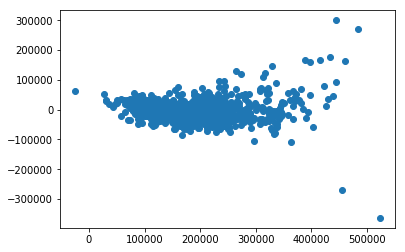

               0
533 -23174.48607


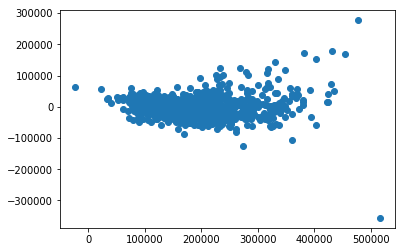

                0
533 -25738.532179


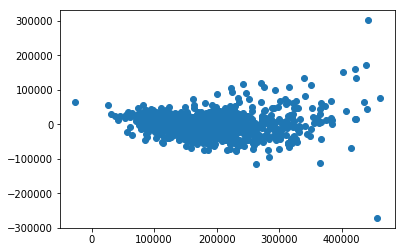

Empty DataFrame
Columns: [0]
Index: []


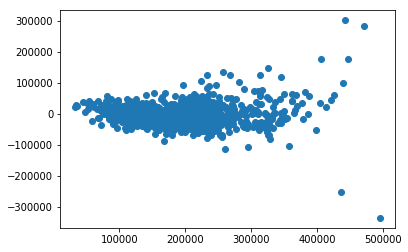

              0
533 -27516.6809


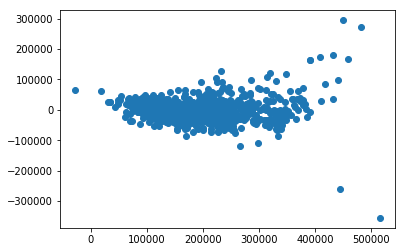

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.813781      13.14     11.765340  1.374660       34570          29011
1  0.827128      12.58     14.240187  1.660187       32136          38752
2  0.834137      12.75     14.051420  1.301420       31514          41523
3  0.805480      12.89     12.884556  0.005444       33912          32474
4  0.815762      12.76     13.638687  0.878687       34272          30388
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.819258  12.824000     13.316038  1.044080  33280.800000   
std    0.011351   0.208159      1.011161  0.644441   1367.029334   
min    0.805480  12.580000     11.765340  0.005444  31514.000000   
25%    0.813781  12.750000     12.884556  0.878687  32136.000000   
50%    0.815762  12.760000     13.638687  1.301420  33912.000000   
75%    0.827128  12.890000     14.051420  1.374660  34272.000000   
max    0.834

In [164]:
print(train_data.shape)
run_model_inputs(train_data, train_saleprice, 5)

NOTE: For 0.05 as min_corr_saleprice
- PCA seems to slightly better (by less than a $1000) when applying on correlation between features > 0.7 and 0.8. However, removing the features perform better by almost $2000 by only removing features that have greater than a 0.9 correlation. 

|min_corr_saleprice| PCA Applied | Removing High Corr Feat | Diff_err | train_rmse | validate_rmse
|-------------------|------|
|   a  | table|

Note that there are some negative train predictions because of correlations within features and lack of correlation with saleprice. This only happens if no features are removed from feature engineering method due to the sentence above.

# Principle Component Regression

In [201]:
# I will use the feature engineering method without removing any columns that correlate with each other
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data before:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
print('Shape of train data:', train_data.shape)
print(train_data.columns)

Shape of train data before: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 110)
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars',
       ...
       'SaleCondition_Partial', 'MSSubClassCat_30', 'MSSubClassCat_45',
       'MSSubClassCat_50', 'MSSubClassCat_60', 'MSSubClassCat_90',
       'MSSubClassCat_120', 'MSSubClassCat_160', 'MSSubClassCat_180',
       'MSSubClassCat_190'],
      dtype='object', length=110)


In [202]:
pca = PCA()
train_pca = pca.fit_transform(train_data)
print('These are the pca components:')
pd.DataFrame(pca.components_.T)

These are the pca components:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109
0,0.098915,-0.016487,-0.002340,0.049276,0.036050,-0.014504,-0.006258,-0.008348,0.022373,-0.071584,-0.016208,0.000625,-0.018787,0.023194,0.013709,-0.001666,0.037998,-0.028584,-0.015781,0.004865,-0.013202,0.001949,-0.033622,-0.010913,-0.058910,0.010912,-0.047388,-0.002912,0.041993,0.068779,0.034719,0.050832,-0.018876,-0.046105,0.024763,0.021734,-0.032534,0.000121,0.035561,-0.063351,0.022157,-0.004511,0.001840,-0.022075,0.081432,0.087350,-0.089446,-0.076845,0.022223,-0.024262,0.017243,0.091717,0.037256,-0.086110,0.002877,0.040283,0.003308,-0.037042,-0.031788,-0.006589,0.034520,-0.019695,0.067231,0.023463,0.049275,-0.057732,-0.009286,0.000039,-0.101558,0.030258,0.089523,-0.144740,-0.015547,0.152558,-0.015117,-0.057514,-0.060940,0.139381,0.124149,0.065774,-0.089913,-0.078208,0.177246,0.128447,0.064196,-0.278502,0.112680,-0.365821,-0.633989,-0.174274,-0.090240,-0.047851,-0.032297,0.087764,0.053407,-0.053490,-0.031500,-0.035315,0.006083,0.100891,0.005524,-0.080258,0.081406,0.002095,0.033205,-0.014364,-0.005942,-0.006789,0.000509,4.344144e-17
1,0.158624,0.027820,-0.011065,-0.015047,-0.035146,0.017614,0.079038,-0.005812,-0.095380,-0.043098,-0.043185,0.060174,0.001186,-0.056575,-0.023585,0.037292,0.039122,-0.031546,-0.023176,0.042639,-0.034318,0.001522,0.045911,0.001677,-0.058761,0.002773,0.100173,-0.066747,0.034689,0.039322,0.015456,-0.036465,-0.005242,0.028109,-0.077459,-0.043059,-0.000009,-0.047662,-0.000172,-0.073997,0.062536,0.040439,-0.031584,-0.048639,-0.127858,0.022163,0.020719,0.001716,-0.064789,0.032947,0.073708,0.018523,-0.017603,-0.027077,0.148249,-0.039550,-0.033054,0.047473,0.024550,0.012166,0.043736,0.012438,0.035747,0.047359,0.053112,0.033410,0.023703,-0.017975,0.002829,0.100171,0.017433,-0.231314,0.130476,-0.016778,-0.216253,0.147824,0.042291,0.001978,0.004807,0.025865,-0.197483,-0.052605,0.075149,0.028900,-0.088565,-0.151540,0.099738,0.183128,-0.001198,-0.050329,0.466266,0.266365,-0.060291,-0.302872,0.183078,-0.152444,0.217558,-0.159725,0.142923,-0.045736,0.006557,0.068365,0.034098,0.012922,-0.012735,0.006027,-0.010336,-0.020461,-0.034094,-2.386744e-16
2,0.207943,-0.074491,-0.052487,-0.018288,-0.004932,-0.055781,0.051478,0.022205,-0.038823,-0.048252,-0.123851,0.080391,0.043716,-0.116406,0.020498,0.010674,0.135829,-0.116631,-0.075189,0.124107,-0.147655,-0.186786,-0.177190,-0.021704,0.125898,0.136218,-0.240546,0.027125,0.089531,0.274855,0.131422,0.147674,-0.162300,-0.001894,-0.075914,0.276318,-0.003872,0.237853,-0.077581,0.339831,0.123313,-0.114023,0.044442,-0.049840,-0.207869,-0.177825,0.061522,0.198129,0.098458,0.083489,0.032989,-0.155032,-0.049037,0.001908,-0.060669,0.020538,-0.052402,0.087943,-0.081086,-0.096138,0.001186,-0.072887,-0.064636,0.020553,0.062186,-0.022499,0.016458,0.006633,-0.007973,0.067114,0.054091,0.021681,0.000767,0.037346,0.040413,-0.036944,-0.004606,-0.025738,0.033069,0.004229,0.014176,0.025714,0.003508,0.009564,0.008110,0.018414,-0.003461,-0.002765,0.018007,0.005627,-0.003541,-0.002203,-0.002654,0.015904,0.012294,-0.003391,-0.002787,-0.009662,-0.006532,-0.000710,-0.004103,0.000126,0.002470,-0.004090,-0.000385,0.005411,-0.000787,0.002918,0.007082,-2.252725e-17
3,0.040700,0.027140,0.019304,0.094049,-0.007447,-0.006270,0.030066,-0.009150,0.030130,0.012239,0.012275,-0.002011,-0.008276,0.003366,0.004650,0.010698,0.002177,-0.002072,-0.012703,0.006764,0.031727,0.014516,-0.003668,-0.009060,-0.004723,-0.008691,-0.014089,-0.010572,0.010793,-0.006416,0.022061,-0.005065,-0.013106,-0.015116,0.021385,0.019375,-0.010934,-0.003272,-0.014113,-0.060845,-0.000707,0.006970,0.053951,0.000558,0.043895,0.033265,-0.013896,-0.003306,0.014894,-0.061177,0.019671,-0.002933,0.054725,-0.063765,0.035342

In [203]:
# Selects 1 - length of the fit and transform pca matrix to 
score_lst = []

for i in range(1, train_pca.shape[1], 1):
    print('iter:', i)
    score_lst.append(run_model_inputs_scores(pd.DataFrame(train_pca[:,:i]), train_saleprice, 5).mean())

iter: 1
KFold(n_splits=5, random_state=8170, shuffle=True)
iter: 2
KFold(n_splits=5, random_state=3993, shuffle=True)
iter: 3
KFold(n_splits=5, random_state=33154, shuffle=True)
iter: 4
KFold(n_splits=5, random_state=37300, shuffle=True)
iter: 5
KFold(n_splits=5, random_state=25260, shuffle=True)
iter: 6
KFold(n_splits=5, random_state=38571, shuffle=True)
iter: 7
KFold(n_splits=5, random_state=20140, shuffle=True)
iter: 8
KFold(n_splits=5, random_state=29214, shuffle=True)
iter: 9
KFold(n_splits=5, random_state=12849, shuffle=True)
iter: 10
KFold(n_splits=5, random_state=23223, shuffle=True)
iter: 11
KFold(n_splits=5, random_state=24105, shuffle=True)
iter: 12
KFold(n_splits=5, random_state=17012, shuffle=True)
iter: 13
KFold(n_splits=5, random_state=28593, shuffle=True)
iter: 14
KFold(n_splits=5, random_state=3990, shuffle=True)
iter: 15
KFold(n_splits=5, random_state=28250, shuffle=True)
iter: 16
KFold(n_splits=5, random_state=31792, shuffle=True)
iter: 17
KFold(n_splits=5, random_st

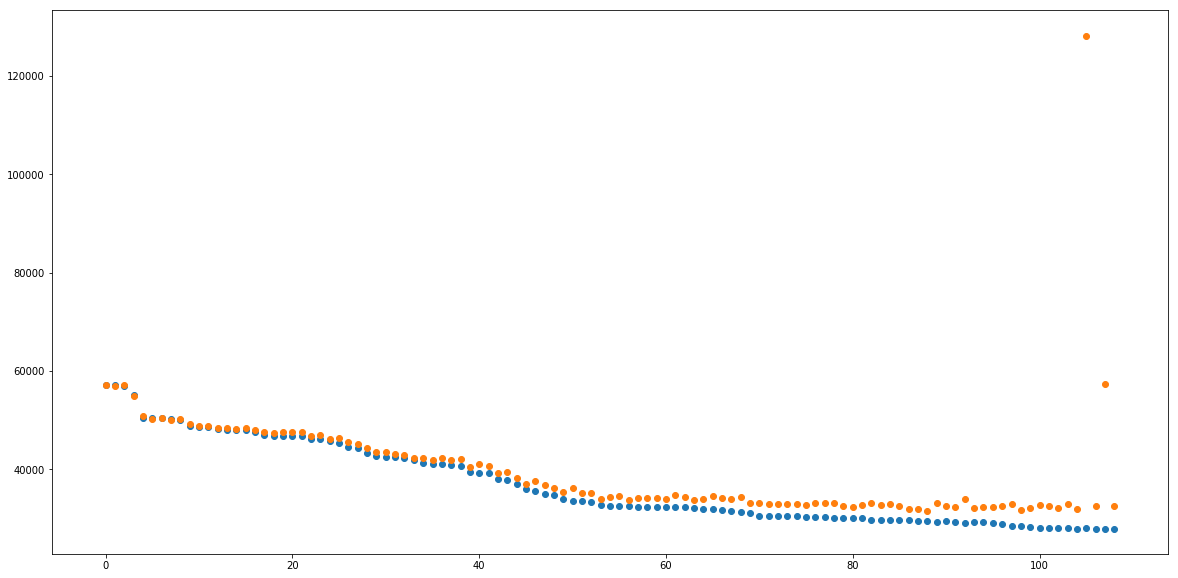

In [204]:
# Plots the train and validation rmse
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df.index , score_lst_df['train_rmse'])
plt.scatter(score_lst_df.index , score_lst_df['validate_rmse'])
plt.show()

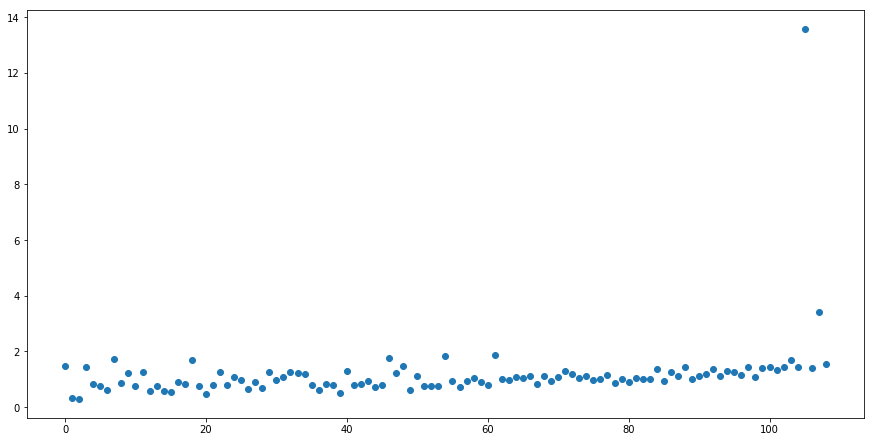

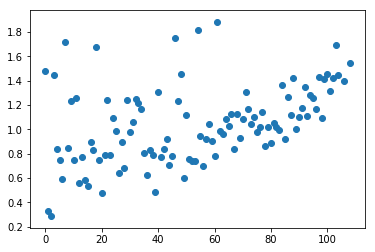

In [208]:
plt.figure(figsize=(15,7.5))
pca_plot = plt.scatter(score_lst_df.index , score_lst_df['diff_err'])
plt.show()

filtered_score_lst_df = score_lst_df[score_lst_df['diff_err'] < 2]
pca_plot = plt.scatter(filtered_score_lst_df.index , filtered_score_lst_df['diff_err'])
plt.show()

In [206]:
pd.DataFrame(score_lst)

,adjr2,train_err,validate_err,diff_err,train_rmse,validate_rmse
0,0.483182,21.900,21.936389,1.478541,57039.2,57141.0
1,0.483039,21.890,21.981135,0.327388,57046.2,57026.6
2,0.483123,21.906,22.020935,0.285725,57007.0,57225.6
3,0.515962,21.378,21.459601,1.446134,55129.0,54947.8
4,0.593596,19.682,19.864600,0.835893,50496.2,50752.2
5,0.593875,19.734,19.836943,0.751342,50454.0,50155.6
6,0.593992,19.804,19.865250,0.593825,50436.4,50478.2
7,0.597621,19.382,19.500058,1.715187,50184.8,49968.4
8,0.598513,19.374,19.488372,0.850187,50119.4,50288.0
9,0.619533,18.354,18.578190,1.233087,48763.4,49131.4


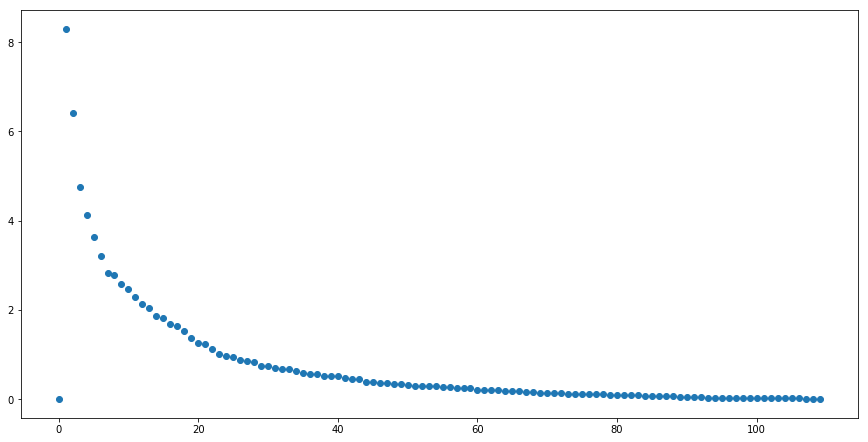

In [207]:
# Following displays the variance explained in the model
a = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
a = pd.DataFrame(a, columns=['var_explained'])

for index, row in a.iterrows():
    if index == 0:
        continue
    a.loc[index, 'diff_var_explained'] = a.loc[index, 'var_explained'] - a.loc[index-1, 'var_explained']

a['diff_var_explained'] = a['diff_var_explained'].fillna(0)
plt.figure(figsize=(15,7.5))
var_explained_plot = plt.scatter(a.index , a['diff_var_explained'])
plt.show()

# Partial Least Squares Regression

In [122]:
def run_model_inputs_pls(train_data, train_saleprice, k, pls_component_no):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        pls2 = PLSRegression(n_components=pls_component_no)
        pls2.fit(sm.add_constant(train_X, has_constant='add'), train_y)
        
#         r2 = PLSRegression.score(sm.add_constant(train_X, has_constant='add'), train_y, sample_weight=None)
        print(pls2.score())
    
        PLSRegression(copy=True, max_iter=500, n_components=pls_component_no, scale=False, tol=1e-06)
        train_predictions = pd.DataFrame(
            pls2.predict(sm.add_constant(train_X, has_constant='add')))
        train_predictions.columns = ['PredSalePrice']
        
        train_y = pd.DataFrame(train_y).reset_index(drop=True)
        train_predictions['SalePrice'] = train_y['SalePrice']
        train_predictions['err'] = train_predictions['PredSalePrice'] - train_y['SalePrice']
        train_predictions['percent_err'] = (abs(train_predictions['err'])/train_predictions['SalePrice'])
#         print(train_predictions.describe())
        
#         # calculations to get percent error
        avg_train_err = round((abs(train_predictions['err'])/train_predictions['SalePrice']).mean()*100,2)
        print(avg_train_err)

        validate_predictions = pd.DataFrame(
            pls2.predict(sm.add_constant(validate_X, has_constant='add')))
        
        validate_predictions.columns = ['PredSalePrice']
        validate_y = pd.DataFrame(validate_y).reset_index(drop=True)
        validate_predictions['SalePrice'] = validate_y['SalePrice']
        validate_predictions['err'] = validate_predictions['PredSalePrice'] - validate_y['SalePrice']
        validate_predictions['percent_err'] = (abs(validate_predictions['err'])/validate_predictions['SalePrice'])
#         print(validate_predictions)
        # calculations to get percent error
        avg_validate_err = round((abs(validate_predictions['err'])/validate_predictions['SalePrice']).mean()*100,2)
        print(avg_validate_err)
        
#         scores.append([model.rsquared_adj, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
#                        round(sqrt(mean_squared_error(train_y, train_predictions))), 
#                        round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

#     scores = pd.DataFrame(scores, columns = ['adjr2', 'train_err', 'validate_err', 'diff_err', 
#                                              'train_rmse', 'validate_rmse'])
#     print(scores)
#     print(scores.describe())
    

#     test_predictions = model.predict(sm.add_constant(test_data))
#     test_predictions = pd.DataFrame(test_predictions)
#     test_predictions.columns = ['SalePrice']
#     test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
#     return test_predictions

In [123]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data before:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
print('Shape of train data:', train_data.shape)

Shape of train data before: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 110)


In [124]:
run_model_inputs_pls(train_data, train_saleprice, 5, 40)

KFold(n_splits=5, random_state=16776, shuffle=True)


TypeError: score() missing 2 required positional arguments: 'X' and 'y'

In [ ]:
pls = PLSRegression(n_components=100)

In [214]:
a = pls.fit_transform(train_data, train_saleprice)

In [221]:
n = len(X_train)
# 10-fold CV, with shuffle
# kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)
# mse = []
# for i in np.arange(40, 50):
#     pls = PLSRegression(n_components=i)
#     score = cross_validation.cross_val_score(pls, X_train, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
#     print(-score)
#     mse.append(-score)
# # Plot results
# plt.plot(np.arange(1, 100), np.array(mse), '-v')
# plt.xlabel('Number of principal components in regression')
# plt.ylabel('MSE')
# plt.title('Salary')
# plt.xlim(xmin=-1)

1211124031.7288828
1210929637.1701312
1210277297.44092
1209898303.583174
1210017815.7219822
1209731615.3688056
1209401780.2505898
1209459023.5769637
1209553735.14993
1209550122.5874372


In [87]:
print(mse)

[1565170979.970074, 1216953098.797951, 1166960896.8458028, 1174937836.1518579, 1188657681.850083, 1196334667.1060975, 1205900054.1497552, 1217424427.391729, 1226314831.40626, 1224301400.922664, 1224817132.3369184, 1224832878.7932916, 1217378791.4943614, 1212116159.096074, 1208579368.669661, 1207227849.4445877, 1205870709.684266, 1204309339.3357558, 1208301019.244634, 1209322908.1523306, 1207335596.5114079, 1205860509.1058753, 1205963711.3742175, 1206408142.601596, 1206533125.06383, 1208011607.097652, 1208781655.850177, 1209075314.9064195, 1210016947.2717593, 1209971532.1786668, 1210066107.4037554, 1210658733.2290711, 1210650886.132186, 1210982947.1441257, 1211541018.9872606, 1211401842.0077577, 1211397961.55014, 1211406157.051034, 1211130546.8561497, 1211124031.7288828, 1210929637.1701312, 1210277297.44092, 1209898303.583174, 1210017815.7219822, 1209731615.3688056, 1209401780.2505898, 1209459023.5769637, 1209553735.14993, 1209550122.5874372, 1209571959.6554332, 1209487398.0769105, 1209

In [ ]:
# Apply regulization and then add zeros to the feature engineering method

In [25]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data before:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.3, 0.75, True)
print('Shape of train data:', train_data.shape)
print(train_data.columns)

model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit_regularized(method='elastic_net', alpha=1000, L1_wt =1)
print('Taking out:', model.params[model.params == 0].shape[0]/model.params.shape[0])
print(model.params[model.params == 0])

Shape of train data before: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 25)
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces',
       'GarageCars', 'NumBath', 'LivingSF', 'NonLivingSF', 'ExterQualInt',
       'BsmtQualInt', 'KitchenQualInt', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Exterior1st_VinylSd', 'MasVnrType_None',
       'MasVnrType_Stone', 'Foundation_PConc', 'HeatingQC_TA',
       'FireplaceQu_Gd', 'GarageType_Attchd', 'GarageType_Detchd',
       'GarageFinish_Unf', 'SaleType_New', 'MSSubClassCat_60'],
      dtype='object')
Taking out: 0.5384615384615384
const                  0.0
YearBuilt              0.0
MasVnrArea             0.0
LivingSF               0.0
NonLivingSF            0.0
ExterQualInt           0.0
BsmtQualInt            0.0
KitchenQualInt         0.0
Exterior1st_VinylSd    0.0
MasVnrType_None        0.0
MasVnrType_Stone       0.0
Foundation_PConc       0.0
GarageType_Attchd      0.0
MSSubClas

In [ ]:
# Try combining features and see if it makes the model better

# K-NN

In [ ]:
# August 28th
# Understand and Finsih PCA regression
# try top 3 model submissions
# Try PLS